<a href="https://colab.research.google.com/github/Juanhernandez1972/Procesamiento-Inteligente-para-el-An-lisis-Educativo-en-Colombia-Saber-Pro-11-/blob/main/Entrega_Final_ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Procesamiento Inteligente para el Análisis Educativo en Colombia (Saber Pro-11)

Este notebook presenta el proceso de extracción, transformación y carga (ETL) de los datos del proyecto Procesamiento Inteligente para el Análisis Educativo en Colombia (Saber Pro-11). Se detallará la carga de los datos provenientes de la base de datos del ICFES a nivel nacional, disponible en el siguiente enlace:
https://www.icfes.gov.co/investigaciones/data-icfes/


# Carga de los datos
Cargaremos los datos provenientes de la base de datos del ICFES. Dado que la descarga se realiza en un archivo TXT, lo almacenaremos en Google Drive para acceder a su contenido y procesarlo posteriormente.

In [ ]:

!pip install pandas requests sqlalchemy

In [ ]:
from google.colab import drive  # Importa la biblioteca necesaria para interactuar con Google Drive en Colab.
drive.mount('/content/drive')  # Monta Google Drive en la ruta especificada, permitiendo acceder a los archivos almacenados en la cuenta vinculada.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import logging
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# ================================
# 1. Creación de la estructura de carpetas
# ================================

def create_project_structure():
    """
    Crea la estructura de carpetas del proyecto ETL.
    Carpetas: config, data, logs, notebooks, src, utils.
    """
    base_path = "/content/ETL_Process"
    folders = ["config", "data", "logs", "notebooks", "src", "utils"]

    for folder in folders:
        path = os.path.join(base_path, folder)
        os.makedirs(path, exist_ok=True)
    print("✅ Estructura del proyecto ETL creada en:", base_path)
    return base_path

In [ ]:
# ================================
# 2. Configuración de Logging
# ================================
def setup_logging(base_path: str):
    """
    Configura el logging para escribir tanto en consola como en un archivo
    dentro de la carpeta logs.
    """
    log_file = os.path.join(base_path, "logs", "etl_log.txt")

    # Eliminar handlers previos para evitar duplicaciones (en caso de re-ejecución)
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=[
            logging.StreamHandler(),  # Imprime en consola
            logging.FileHandler(log_file, mode='a', encoding='utf-8')  # Guarda en archivo
        ]
    )
    logging.info(f"Logging configurado. Archivo de log: {log_file}")

In [ ]:
# ================================
# 3. Funciones de Utilidad
# ================================
def mount_drive():
    """
    Monta Google Drive en Colab para acceder a los archivos.
    """
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        logging.info("Google Drive montado correctamente.")
    except Exception as e:
        logging.error(f"Error al montar Google Drive: {e}")
        raise

def find_file_path(filename, root_dir="/content/drive/My Drive"):
    """
    Busca la ruta completa de un archivo en el directorio raíz especificado.

    Args:
        filename (str): Nombre del archivo a buscar.
        root_dir (str): Directorio raíz donde iniciar la búsqueda.

    Returns:
        str or None: Ruta completa si se encuentra el archivo, de lo contrario None.
    """
    for dirpath, dirnames, files in os.walk(root_dir):
        if filename in files:
            full_path = os.path.join(dirpath, filename)
            logging.info(f"Archivo encontrado: {full_path}")
            return full_path
    logging.warning(f"Archivo {filename} no encontrado en {root_dir}.")
    return None

In [ ]:
# ================================
# 4. Función de Extracción (Extract)
# ================================
def extract_data(filename="SB11_20232.TXT", sep="¬", encoding="utf-8"):
    """
    Extrae los datos de un archivo TXT usando pandas.

    Args:
        filename (str): Nombre del archivo a extraer.
        sep (str): Delimitador utilizado en el archivo.
        encoding (str): Codificación del archivo.

    Returns:
        DataFrame: DataFrame con los datos cargados.
    """
    # Montar Google Drive
    mount_drive()

    # Buscar el archivo en Drive
    file_path = find_file_path(filename)
    if not file_path:
        raise FileNotFoundError(f"El archivo {filename} no fue encontrado en Google Drive.")

    try:
        df = pd.read_csv(file_path, sep=sep, engine='python', encoding=encoding)
        logging.info(f"Datos extraídos correctamente desde {file_path}. Filas: {len(df)}")
        return df
    except Exception as e:
        logging.error(f"Error al leer el archivo {file_path}: {e}")
        raise

In [ ]:
# ================================
# 5. Función de Transformación (Transform)
# ================================

def transform_data(df):
    """
    Aplica una serie de transformaciones y validaciones al DataFrame.

    Proceso:
      - Reporte de valores nulos y eliminación de columnas con >10% nulos.
      - Eliminación de filas con cualquier valor nulo.
      - Exploración de valores únicos (validación) en cada columna.
      - Transformaciones de variables binarias y cualitativas.
      - Conversión de fecha de nacimiento y cálculo de la edad.

    Args:
        df (DataFrame): DataFrame original extraído.

    Returns:
        DataFrame: DataFrame transformado.
    """
    # Configurar pandas para mostrar todas las columnas
    pd.set_option('display.max_columns', None)

    # --- Reporte de valores nulos ---
    null_counts = df.isnull().sum()
    total_rows = len(df)
    null_percentage = (null_counts / total_rows) * 100
    null_counts_df = pd.DataFrame({
        'Nombre de la columna': null_counts.index,
        'Número de valores nulos': null_counts.values,
        'Porcentaje de valores nulos': null_percentage.values
    })
    null_counts_df = null_counts_df[null_counts_df['Número de valores nulos'] > 0]\
                         .sort_values(by='Número de valores nulos', ascending=False)
    logging.info("Reporte de valores nulos:\n" + null_counts_df.to_string(index=False))

    # --- Eliminación de columnas con >10% de nulos ---
    threshold = 0.1 * len(df)
    columns_to_drop = df.columns[df.isnull().sum() > threshold]
    df.drop(columns=columns_to_drop, inplace=True)
    logging.info(f"Columnas eliminadas por tener >10% valores nulos: {list(columns_to_drop)}")

    # --- Eliminación de filas con al menos un nulo ---
    df = df.dropna()
    logging.info(f"Nuevo shape del DataFrame tras eliminar filas con nulos: {df.shape}")

    # --- (Opcional) Exploración y validación de datos ---
    # Puedes descomentar el siguiente bloque si deseas imprimir los valores únicos de cada columna.
    """
    for col in df.columns:
        logging.info(f"Columna: {col}")
        logging.info(f"Valores únicos: {df[col].unique()}")
        logging.info("-" * 40)
    """

    # --- Transformaciones específicas ---
    # Transformaciones de columnas binarias
    binary_cols = [
        "ESTU_PRESENTACIONSABADO", "FAMI_TIENEINTERNET", "FAMI_TIENECOMPUTADOR",
        "FAMI_TIENELAVADORA", "FAMI_TIENEHORNOMICROOGAS", "FAMI_TIENESERVICIOTV",
        "FAMI_TIENEAUTOMOVIL", "FAMI_TIENEMOTOCICLETA", "FAMI_TIENECONSOLAVIDEOJUEGOS",
        "ESTU_GENERACION"
    ]
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.capitalize()
            df[col] = df[col].map({"Si": 1, "No": 0})

    # Transformación de 'FAMI_ESTRATOVIVIENDA': quitar "Estrato "
    if 'FAMI_ESTRATOVIVIENDA' in df.columns:
        df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].str.replace('Estrato ', '', regex=False)

    # Transformación de 'FAMI_CUARTOSHOGAR'
    mapping_cuartos = {
        'Uno': '1',
        'Dos': '2',
        'Tres': '3',
        'Cuatro': '4',
        'Cinco': '5',
        'Seis o mas': '[6+]'
    }
    if 'FAMI_CUARTOSHOGAR' in df.columns:
        df['FAMI_CUARTOSHOGAR'] = df['FAMI_CUARTOSHOGAR'].map(mapping_cuartos)

    # Transformación de 'FAMI_PERSONASHOGAR'
    if 'FAMI_PERSONASHOGAR' in df.columns:
        def transform_personas(val):
            val = str(val).strip()
            if " a " in val:
                parts = val.split(" a ")
                if len(parts) == 2:
                    return f'[{parts[0]}-{parts[1]}]'
                else:
                    return val
            elif "o más" in val:
                parts = val.split()
                if parts:
                    return f'[{parts[0]}+]'
                else:
                    return val
            else:
                return val
        df['FAMI_PERSONASHOGAR'] = df['FAMI_PERSONASHOGAR'].apply(transform_personas)

    # Transformación de 'FAMI_NUMLIBROS'
    if 'FAMI_NUMLIBROS' in df.columns:
        def transform_libros(val):
            val = str(val).strip()
            if ' A ' in val:
                parts = val.split(' A ')
                if len(parts) >= 2:
                    lower = parts[0].strip()
                    upper = parts[1].split()[0].strip()
                    return f'[{lower}-{upper}]'
                else:
                    return val
            elif 'MÁS DE' in val.upper():
                parts = val.split()
                if len(parts) >= 3:
                    return f'[{parts[2]}+]'
                else:
                    return val
            else:
                return val
        df['FAMI_NUMLIBROS'] = df['FAMI_NUMLIBROS'].apply(transform_libros)

    # Mapeo de variables de dedicación y horas
    mapping_internet = {
        'Entre 30 y 60 minutos': '[0.5-1]',
        'Entre 1 y 3 horas': '[1-3]',
        '30 minutos o menos': '[<=0.5]',
        'Más de 3 horas': '[>3]',
        'No Navega Internet': '[0]'
    }
    if 'ESTU_DEDICACIONINTERNET' in df.columns:
        df['ESTU_DEDICACIONINTERNET'] = df['ESTU_DEDICACIONINTERNET'].map(mapping_internet)

    mapping_horas = {
        'Entre 21 y 30 horas': '[21-30]',
        'Menos de 10 horas': '[<10]',
        '0': '[0]',
        'Entre 11 y 20 horas': '[11-20]',
        'Más de 30 horas': '[>30]'
    }
    if 'ESTU_HORASSEMANATRABAJA' in df.columns:
        df['ESTU_HORASSEMANATRABAJA'] = df['ESTU_HORASSEMANATRABAJA'].map(mapping_horas)

    mapping_horasLectura = {
        '30 minutos o menos': '[<=0.5]',
        'Entre 30 y 60 minutos': '[0.5-1]',
        'No leo por entretenimiento': '[0]',
        'Más de 2 horas': '[>2]',
        'Entre 1 y 2 horas': '[1-2]'
    }
    if 'ESTU_DEDICACIONLECTURADIARIA' in df.columns:
        df['ESTU_DEDICACIONLECTURADIARIA'] = df['ESTU_DEDICACIONLECTURADIARIA'].map(mapping_horasLectura)

    # Limpiar espacios en 'COLE_SEDE_PRINCIPAL'
    if 'COLE_SEDE_PRINCIPAL' in df.columns:
        df['COLE_SEDE_PRINCIPAL'] = df['COLE_SEDE_PRINCIPAL'].str.strip()

    # --- Creación de la variable EDAD ---
    if "ESTU_FECHANACIMIENTO" in df.columns:
        # Convertir la columna a datetime, convirtiendo errores a NaT
        df["ESTU_FECHANACIMIENTO"] = pd.to_datetime(df["ESTU_FECHANACIMIENTO"], format="%d/%m/%Y", errors="coerce")
        # Comprobar cuántos valores NA quedan en la columna
        na_count = df["ESTU_FECHANACIMIENTO"].isna().sum()
        if na_count > 0:
            logging.warning(f"Se encontraron {na_count} registros con fecha de nacimiento no válidas. Se eliminarán estas filas.")
            # Elimina las filas que tengan NaT en la fecha
            df = df.dropna(subset=["ESTU_FECHANACIMIENTO"])
        # Calcular la edad
        df["EDAD"] = ((pd.to_datetime("today") - df["ESTU_FECHANACIMIENTO"]).dt.days // 365).astype(int)
        logging.info("Variable EDAD creada a partir de ESTU_FECHANACIMIENTO.")

    logging.info("Valores nulos en ESTU_FECHANACIMIENTO después del drop: " +
                 str(df["ESTU_FECHANACIMIENTO"].isna().sum()))

    return df

In [ ]:
# ================================
# 6. Función de Carga (Load)
# ================================
def load_data(df, output_filename="dataICFES.csv", base_path=None):
    """
    Guarda el DataFrame transformado en un archivo CSV.

    Args:
        df (DataFrame): DataFrame transformado.
        output_filename (str): Nombre del archivo de salida.
        base_path (str): Ruta base del proyecto.

    Returns:
        str: Ruta completa del archivo guardado.
    """
    if base_path is None:
        base_path = "/content/ETL_Process"
    output_path = os.path.join(base_path, "data", output_filename)

    try:
        df.to_csv(output_path, index=False, encoding="utf-8")
        logging.info(f"Archivo CSV generado exitosamente en: {output_path}")
        return output_path
    except Exception as e:
        logging.error(f"Error al guardar el archivo CSV: {e}")
        raise

In [ ]:
# ================================
# 7. Pipeline Principal (ETL)
# ================================
def run_etl():
    """
    Orquesta la ejecución completa del proceso ETL:
      1. Creación de la estructura de carpetas.
      2. Configuración del logging.
      3. Extracción de datos.
      4. Transformación de los datos.
      5. Carga de los datos transformados en un CSV.
      6. (Opcional) Análisis exploratorio.
    """
    # 1. Crear estructura de carpetas
    base_path = create_project_structure()

    # 2. Configurar logging
    setup_logging(base_path)

    logging.info("Inicio del proceso ETL")
    print("Inicio del proceso ETL.")

    # 3. Extracción
    df_raw = extract_data()  # Lee "SB11_20232.TXT" desde Google Drive
    print("Extracción Finalizado.")

    # 4. Transformación
    df_transformed = transform_data(df_raw)
    print("Transformación Finalizado.")

    # 5. Carga
    output_file = load_data(df_transformed, base_path=base_path)
    print("Carga Finalizado.")


    logging.info("Proceso ETL finalizado.")
    print("Proceso ETL finalizado.")

# Ejecutar el pipeline ETL
run_etl()

2025-04-06 00:14:45,832 - INFO - Logging configurado. Archivo de log: /content/ETL_Process/logs/etl_log.txt
2025-04-06 00:14:45,834 - INFO - Inicio del proceso ETL


✅ Estructura del proyecto ETL creada en: /content/ETL_Process
Inicio del proceso ETL.


2025-04-06 00:14:46,847 - INFO - Google Drive montado correctamente.
2025-04-06 00:14:46,850 - INFO - Archivo encontrado: /content/drive/My Drive/Colab Notebooks/SB11_20232.TXT


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2025-04-06 00:15:45,106 - INFO - Datos extraídos correctamente desde /content/drive/My Drive/Colab Notebooks/SB11_20232.TXT. Filas: 551149


Extracción Finalizado.


2025-04-06 00:15:47,769 - INFO - Reporte de valores nulos:
         Nombre de la columna  Número de valores nulos  Porcentaje de valores nulos
            ESTU_LENGUANATIVA                   541839                    98.310802
    PERCENTIL_ESPECIAL_GLOBAL                   507677                    92.112478
                COLE_BILINGUE                   102248                    18.551789
      FAMI_COMELECHEDERIVADOS                    50599                     9.180639
FAMI_COMECEREALFRUTOSLEGUMBRE                    49234                     8.932975
         FAMI_ESTRATOVIVIENDA                    49105                     8.909569
               FAMI_NUMLIBROS                    48493                     8.798528
      ESTU_DEDICACIONINTERNET                    46088                     8.362167
   FAMI_COMECARNEPESCADOHUEVO                    45826                     8.314630
         FAMI_TIENESERVICIOTV                    45184                     8.198146
 ESTU_DEDICACIONL

Transformación Finalizado.


2025-04-06 00:16:24,767 - INFO - Archivo CSV generado exitosamente en: /content/ETL_Process/data/dataICFES.csv
2025-04-06 00:16:24,768 - INFO - Proceso ETL finalizado.


Carga Finalizado.
Proceso ETL finalizado.


# Exploración y Transformación de Datos

En esta sección se llevará a cabo un análisis exploratorio inicial con el objetivo de identificar y aplicar las transformaciones necesarias para limpiar y estructurar adecuadamente los datos. Se evaluará la presencia de valores nulos y se determinará el mejor método para imputarlos o eliminarlos según corresponda.

Además, se revisarán las variables categóricas que, por su naturaleza, requieran conversión a formato numérico para facilitar su análisis y mejorar su utilidad en modelos posteriores. También se normalizarán los datos, eliminando espacios innecesarios y caracteres no relevantes, con el fin de optimizar su organización y procesamiento.


**Reasoning**:
Explore the data by displaying basic info, data types, missing values, summary statistics, and unique value counts.



## Eliminación de columnas con mayor cantidad de valores nulos

En esta sección, eliminaremos las columnas que presentan más del 10% de valores nulos. Si aplicáramos el método .dropna() a todo el DataFrame, perderíamos una gran cantidad de datos.

En particular, eliminaremos las columnas "ESTU_LENGUANATIVA", "PERCENTIL_ESPECIAL_GLOBAL" y "COLE_BILINGUE", ya que presentan entre un 18% y 98% de valores faltantes. Además, el alto porcentaje de datos ausentes dificulta significativamente una posible imputación confiable.

**Eliminación de valores nulos**

En esta sección, eliminaremos los valores nulos restantes. Como se observa en los gráficos, la mayoría de estos valores se repiten en las mismas filas a lo largo de varias variables.

Además, en todas las variables con valores nulos, el porcentaje de datos faltantes no supera el 10%, por lo que su eliminación no afectará significativamente la distribución general de los datos.

**Exploración y validación de datos**

Verificar los distintos valores que toman las columnas

## Transformaciones de Columnas

**Variables Binarias**

Al transformar estas columnas de respuestas binarias (por ejemplo, "Sí" y "No") en valores numéricos 1 y 0, se estandariza la representación de categorías dicotómicas, lo que facilita el cálculo de métricas estadísticas como sumas y promedios, además de mejorar la integración de estas variables en modelos de machine learning o análisis de regresión. Asimismo, esta conversión ayuda a evitar inconsistencias derivadas de variaciones en la escritura de las respuestas (uso de tildes, mayúsculas o espacios adicionales), garantizando así mayor calidad y coherencia en los datos.

**Variables Cualitativas con más categorias**

**FAMI_ESTRATOVIVIENDA** se elimina la palabra “Estrato” para dejar solamente el número. Esta transformación busca normalizar los datos relacionados con la clasificación socioeconómica de la vivienda, de modo que el análisis estadístico sea más sencillo al contar con valores numéricos claros (1, 2, 3, etc.) en lugar de cadenas de texto más extensas.

**FAMI_CUARTOSHOGAR** se mapean valores en español como “Uno”, “Dos”, “Tres” a representaciones numéricas y se agrupan en una categoría “[6+]” cuando se trata de “Seis o más”. El objetivo es homogenizar la información sobre el número de cuartos y facilitar comparaciones entre viviendas con distinto espacio habitacional.

**FAMI_PERSONASHOGAR** se transforman expresiones como “1 a 2” o “9 o más” en intervalos con corchetes, por ejemplo “[1-2]” y “[9+]”. Esto unifica el formato de la variable y ayuda a segmentar o agrupar rápidamente los hogares según el número de personas que los integran.

**FAMI_NUMLIBROS** se estandarizan los rangos de libros con un formato de corchetes, pasando de expresiones como “0 A 10 LIBROS” o “MÁS DE 100 LIBROS” a “[0-10]” o “[100+]”. Esta conversión facilita la categorización del entorno lector del hogar y potencia análisis comparativos respecto al nivel sociocultural.

**ESTU_DEDICACIONINTERNET** se convierten valores como “Entre 30 y 60 minutos” o “Más de 3 horas” a un formato de horas entre corchetes, por ejemplo “[0.5-1]” y “[>3]”. Esta homogeneización permite comparar de forma sistemática el tiempo que los estudiantes dedican a internet, una variable relevante en estudios de hábitos de estudio y acceso tecnológico.

**ESTU_HORASSEMANATRABAJA** se crean intervalos predefinidos para la cantidad de horas de trabajo, reemplazando “Entre 21 y 30 horas” o “Menos de 10 horas” con valores como “[21-30]” o “[<10]”. Esta aproximación permite clasificar y filtrar la población estudiantil según el tiempo que invierten en actividades laborales semanales, lo cual puede influir en su desempeño académico.

**ESTU_DEDICACIONLECTURADIARIA** se asignan intervalos con corchetes para expresar de manera uniforme el tiempo dedicado a la lectura diaria, pasando de valores textuales como “30 minutos o menos” o “No leo por entretenimiento” a formatos como “[<=0.5]” o “[0]”. Esto estandariza la variable y facilita la comparación cuantitativa de los hábitos de lectura entre diferentes grupos de estudiantes, lo que resulta útil para correlacionar el tiempo de lectura con el desempeño académico u otras características sociodemográficas.

**COLE_SEDE_PRINCIPAL** se eliminan los espacios adicionales en valores como “S ” o “N ”, de modo que la columna quede únicamente con “S” o “N”. Con esto se evitan inconsistencias y errores en la base de datos, especialmente al realizar agrupaciones, cruces de tablas o visualizaciones basadas en dichas categorías.

A continuación, validamos cada uno de los cambios en las variables correspondientes.

Se Creo una nueva variable de EDAD a partir de la variable ESTU_FECHANACIMIENTO.

# Exploratory Data Analysis (EDA)

In [ ]:
df.head(10)

In [ ]:
import pandas as pd

# 1. Excluir columnas que tengan "COD" en su nombre (ignorar mayúsculas/minúsculas)
columns_without_cod = [col for col in df.columns if 'COD' not in col.upper()]

# Creamos un nuevo DataFrame con las columnas filtradas
df_filtered = df[columns_without_cod].copy()

# 2. Identificar y convertir a categoría (factor) las columnas que solo tengan valores 0 y 1
for col in df_filtered.columns:
    # Verificamos si la columna es de tipo numérico
    if pd.api.types.is_numeric_dtype(df_filtered[col]):
        # Tomamos los valores únicos (sin nulos)
        unique_vals = df_filtered[col].dropna().unique()

        # Chequeamos si el conjunto de valores está dentro de {0,1}
        if set(unique_vals).issubset({0, 1}):
            df_filtered[col] = df_filtered[col].astype('category')

# Ahora df_filtered contiene:
# - No columnas con 'COD' en su nombre.
# - Columnas con valores 0/1 convertidas a categoría.


In [ ]:
# Variables numéricas
num_cols = df_filtered.select_dtypes(include=['number']).columns.tolist()

# Variables categóricas (tipo object)
cat_cols = df_filtered.select_dtypes(include=['object']).columns.tolist()

print("Variables numéricas:", num_cols)
print("Variables categóricas:", cat_cols)


Variables numéricas: ['PERIODO', 'PUNT_LECTURA_CRITICA', 'PERCENTIL_LECTURA_CRITICA', 'DESEMP_LECTURA_CRITICA', 'PUNT_MATEMATICAS', 'PERCENTIL_MATEMATICAS', 'DESEMP_MATEMATICAS', 'PUNT_C_NATURALES', 'PERCENTIL_C_NATURALES', 'DESEMP_C_NATURALES', 'PUNT_SOCIALES_CIUDADANAS', 'PERCENTIL_SOCIALES_CIUDADANAS', 'DESEMP_SOCIALES_CIUDADANAS', 'PUNT_INGLES', 'PERCENTIL_INGLES', 'PUNT_GLOBAL', 'PERCENTIL_GLOBAL', 'ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'EDAD']
Variables categóricas: ['ESTU_TIPODOCUMENTO', 'ESTU_NACIONALIDAD', 'ESTU_GENERO', 'ESTU_CONSECUTIVO', 'ESTU_ESTUDIANTE', 'ESTU_PAIS_RESIDE', 'ESTU_DEPTO_RESIDE', 'ESTU_MCPIO_RESIDE', 'FAMI_ESTRATOVIVIENDA', 'FAMI_PERSONASHOGAR', 'FAMI_CUARTOSHOGAR', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_TRABAJOLABORPADRE', 'FAMI_TRABAJOLABORMADRE', 'FAMI_NUMLIBROS', 'FAMI_COMELECHEDERIVADOS', 'FAMI_COMECARNEPESCADOHUEVO', 'FAMI_COMECEREALFRUTOSLEGUMBRE', 'FAMI_SITUACIONECONOMICA', 'ESTU_DEDICACIONLECTURADIAR

In [ ]:
for col in num_cols:
    unique_count = df_filtered[col].nunique()
    print(f"{col}: {unique_count} valores únicos")
    if unique_count < 20:
        print(df_filtered[col].unique())
        print("-" * 40)


In [ ]:
# Seleccionar variables categóricas del DataFrame filtrado
cat_cols_filtered = df_filtered.select_dtypes(include=['object', 'category']).columns.tolist()

# Mostrar los valores únicos para cada variable categórica
for col in cat_cols_filtered:
    unique_count = df_filtered[col].nunique()
    print(f"{col}: {unique_count} valores únicos")
    if unique_count < 20:
        print(df_filtered[col].unique())
        print("-" * 40)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Histograma de puntaje global
plt.figure(figsize=(10,5))
sns.histplot(df_filtered["PUNT_GLOBAL"], bins=30, kde=True)
plt.title("Distribución del Puntaje Global en Colombia")
plt.xlabel("Puntaje Global")
plt.show()

La distribución del Puntaje Global en Colombia, según la gráfica, muestra una forma aproximadamente simétrica, con un pico central alrededor de los 250-300 puntos, lo que indica que la mayoría de los estudiantes se agrupa en este rango. Este comportamiento sugiere que, si bien existe un número reducido de puntajes muy bajos y muy altos, la gran parte de la población evaluada se concentra en niveles de desempeño intermedio. Esta tendencia puede reflejar, por un lado, cierta homogeneidad en la calidad educativa o en las oportunidades de formación que reciben los estudiantes, pero también evidencia la necesidad de investigar qué factores permiten que algunos sobresalgan con puntajes altos y por qué otros quedan rezagados en el extremo inferior de la distribución.


## Variables Cualitativas

In [ ]:
cat_cols_filtered = df_filtered.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols_filtered:
    print(f"{col}: {df_filtered[col].nunique()} valores únicos")
    print(df_filtered[col].value_counts().head(10))  # Muestra los 10 valores más frecuentes
    print("-" * 40)


## Análisis Bivariado

<ipython-input-77-2defb98523ec>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


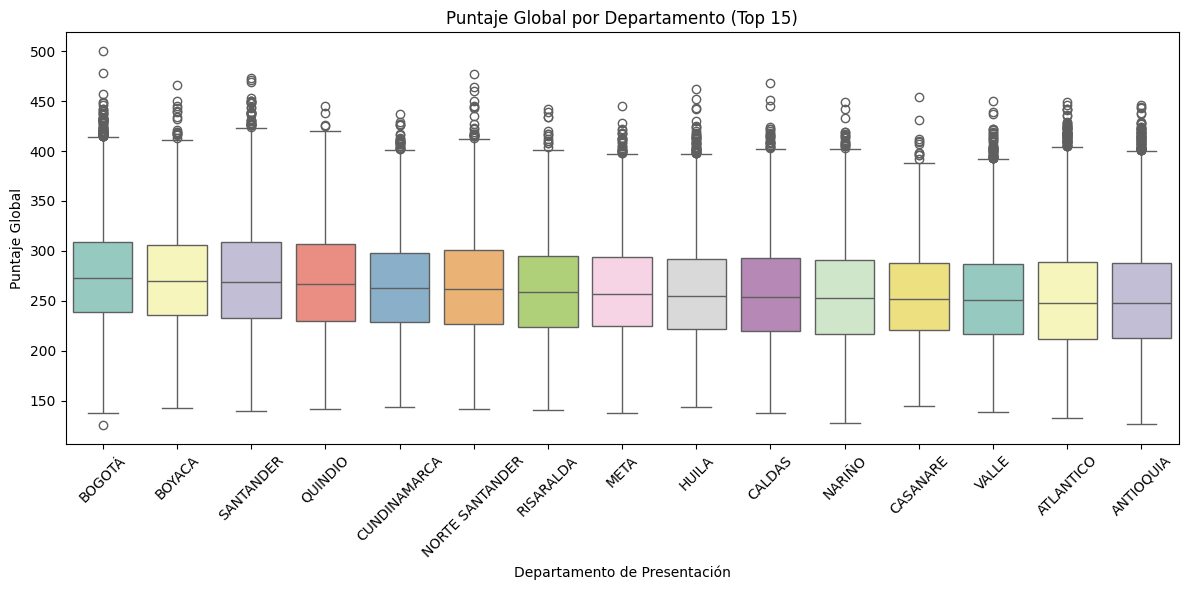

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la mediana de PUNT_GLOBAL por departamento y seleccionar el top 15
dept_order = (
    df_filtered.groupby('ESTU_DEPTO_PRESENTACION')['PUNT_GLOBAL']
    .median()
    .sort_values(ascending=False)
    .head(15)
    .index
)

# Filtrar el DataFrame para incluir solo los departamentos del top 15
df_top_dept = df_filtered[df_filtered['ESTU_DEPTO_PRESENTACION'].isin(dept_order)]

plt.figure(figsize=(12,6))
sns.boxplot(
    x="ESTU_DEPTO_PRESENTACION",
    y="PUNT_GLOBAL",
    data=df_top_dept,
    order=dept_order,
    palette="Set3"
)
plt.xticks(rotation=45)
plt.title("Puntaje Global por Departamento (Top 15)")
plt.xlabel("Departamento de Presentación")
plt.ylabel("Puntaje Global")
plt.tight_layout()
plt.show()


In [ ]:
# 4. Obtener las estadísticas descriptivas por departamento
stats_by_dept = (
    df_top_dept
    .groupby('ESTU_DEPTO_PRESENTACION')['PUNT_GLOBAL']
    .describe()
    .loc[dept_order]  # Opcional: para mantener el mismo orden que el boxplot
)

# 5. Mostrar la tabla de estadísticas
print(stats_by_dept)

Los resultados muestran que departamentos como Bogotá, Boyacá y Santander presentan medianas de puntaje ICFES más altas, lo que sugiere una concentración de mejores desempeños académicos en zonas con mayores recursos educativos y socioeconómicos. En Colombia, factores como la disponibilidad de infraestructura escolar, el nivel de ingreso de las familias y el acceso a programas de refuerzo académico influyen de forma significativa en los resultados de las pruebas. Al observar el departamento del Valle, se aprecia que, si bien no ocupa las primeras posiciones, mantiene una dispersión notable en los puntajes, lo cual podría indicar desigualdades internas: existen estudiantes con muy buen desempeño, pero también grupos con resultados más bajos. Estas diferencias pueden estar relacionadas con factores sociodemográficos (por ejemplo, la brecha urbano-rural o el nivel de ingresos familiares), la calidad de la formación docente y la inversión en educación, entre otros elementos que varían de un municipio a otro dentro del mismo departamento.

<ipython-input-76-6c9508d443c5>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="ESTU_MCPIO_PRESENTACION", y="PUNT_GLOBAL", data=df_top, order=muni_order, palette="Set3")


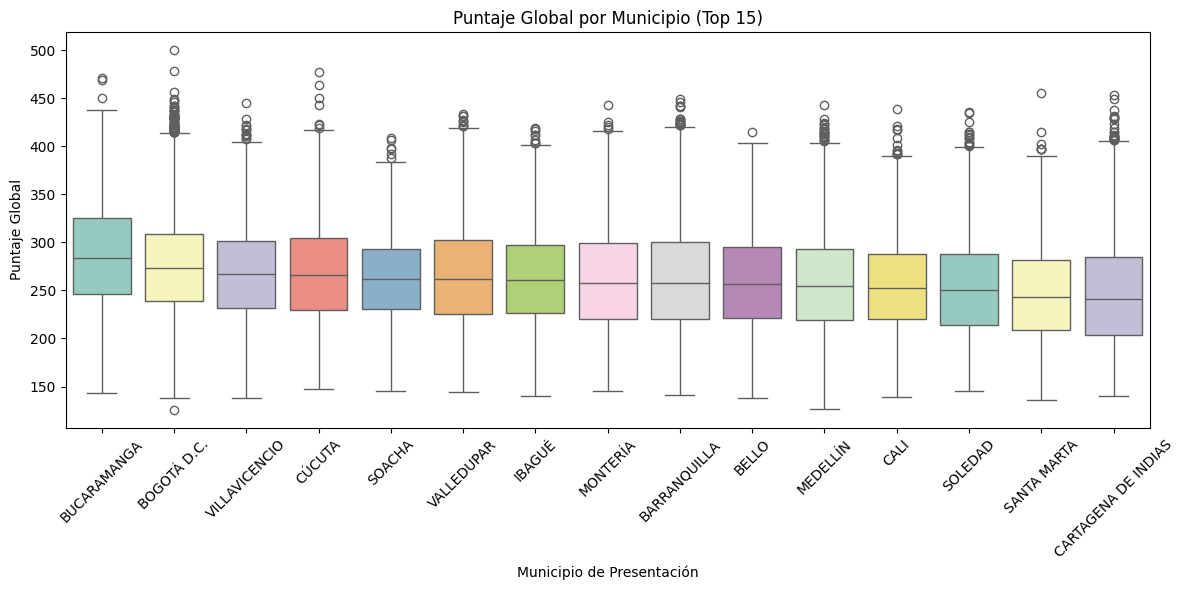

                           count        mean        std    min     25%    50%  \
ESTU_MCPIO_PRESENTACION                                                         
BUCARAMANGA               6020.0  285.403322  53.758066  143.0  246.00  284.0   
BOGOTÁ D.C.              65022.0  274.257036  48.276320  126.0  239.00  273.0   
VILLAVICENCIO             5158.0  268.410043  49.439126  138.0  232.00  267.0   
CÚCUTA                    8580.0  268.333800  51.379973  147.0  230.00  266.0   
SOACHA                    6372.0  262.847615  43.429354  145.0  231.00  262.0   
VALLEDUPAR                4814.0  265.577482  53.470530  144.0  225.00  261.5   
IBAGUÉ                    6391.0  263.455484  49.091775  140.0  227.00  261.0   
MONTERÍA                  5768.0  261.550798  52.239404  145.0  220.00  258.0   
BARRANQUILLA             13588.0  261.347954  53.676257  141.0  220.00  258.0   
BELLO                     4762.0  258.624318  48.716134  138.0  221.25  257.0   
MEDELLÍN                 210

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Seleccionar el top 15 de municipios con mayor cantidad de registros
top_municipios = df_filtered['ESTU_MCPIO_PRESENTACION'].value_counts().nlargest(15).index

# Filtrar el DataFrame para incluir solo esos municipios
df_top = df_filtered[df_filtered['ESTU_MCPIO_PRESENTACION'].isin(top_municipios)]

# 2. Calcular la mediana de PUNT_GLOBAL para cada municipio y ordenar de mayor a menor
muni_order = (
    df_top.groupby('ESTU_MCPIO_PRESENTACION')['PUNT_GLOBAL']
    .median()
    .sort_values(ascending=False)
    .index
)

# 3. Graficar el boxplot del Puntaje Global por Municipio (Top 15) ordenados con una paleta de colores bonita
plt.figure(figsize=(12,6))
sns.boxplot(x="ESTU_MCPIO_PRESENTACION", y="PUNT_GLOBAL", data=df_top, order=muni_order, palette="Set3")
plt.xticks(rotation=45)
plt.title("Puntaje Global por Municipio (Top 15)")
plt.xlabel("Municipio de Presentación")
plt.ylabel("Puntaje Global")
plt.tight_layout()
plt.show()

# 4. Obtener las estadísticas descriptivas del Puntaje Global para cada municipio del Top 15
stats_by_muni = (
    df_top.groupby('ESTU_MCPIO_PRESENTACION')['PUNT_GLOBAL']
    .describe()
    .loc[muni_order]
)
print(stats_by_muni)


A nivel municipal, se evidencia cómo ciudades como Bucaramanga y Bogotá presentan medianas de puntaje más altas, lo que coincide con su condición de centros urbanos con mayor inversión y acceso a recursos educativos. No obstante, la dispersión en otras urbes, como Cali y Barranquilla, indica que existen brechas internas, reflejadas en la presencia de resultados muy altos junto a desempeños considerablemente más bajos. Estas variaciones apuntan a que factores locales (disponibilidad de instituciones de calidad, políticas municipales y diferencias socioeconómicas entre barrios) pueden ser tan determinantes como los departamentales. Asimismo, municipios como Soledad y Cartagena de Indias muestran valores medianos más moderados, sugiriendo oportunidades de mejora en aspectos de infraestructura educativa y condiciones familiares que influyen en el rendimiento de los estudiantes.

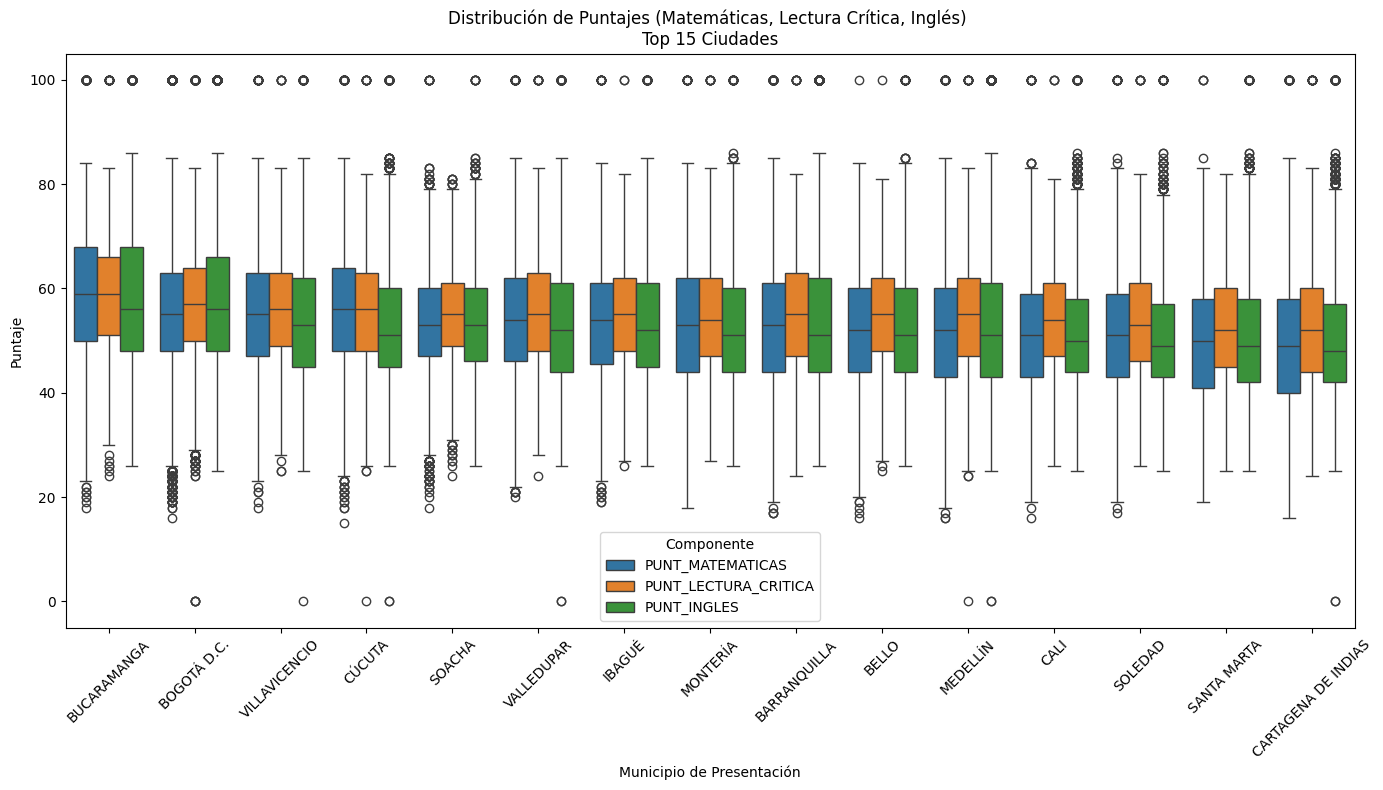

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. Seleccionar las mismas 15 ciudades con mayor cantidad de registros
# -----------------------------
top_municipios = df_filtered['ESTU_MCPIO_PRESENTACION'].value_counts().nlargest(15).index
df_top = df_filtered[df_filtered['ESTU_MCPIO_PRESENTACION'].isin(top_municipios)].copy()

# -----------------------------
# 2. Ordenar los municipios según la mediana de PUNT_GLOBAL (de mayor a menor)
# -----------------------------
muni_order = (
    df_top
    .groupby('ESTU_MCPIO_PRESENTACION')['PUNT_GLOBAL']
    .median()
    .sort_values(ascending=False)
    .index
)

# -----------------------------
# 3. Transformar el DataFrame a formato "long" para los componentes de interés
# -----------------------------
df_long = pd.melt(
    df_top,
    id_vars=['ESTU_MCPIO_PRESENTACION'],
    value_vars=['PUNT_MATEMATICAS', 'PUNT_LECTURA_CRITICA', 'PUNT_INGLES'],
    var_name='Componente',
    value_name='Puntaje'
)

# -----------------------------
# 4. Crear el boxplot agrupado con el orden basado en la mediana de PUNT_GLOBAL
# -----------------------------
plt.figure(figsize=(14,8))
sns.boxplot(
    x='ESTU_MCPIO_PRESENTACION',
    y='Puntaje',
    hue='Componente',
    data=df_long,
    order=muni_order  # Mantenemos el mismo orden que en PUNT_GLOBAL
)

plt.xticks(rotation=45)
plt.title("Distribución de Puntajes (Matemáticas, Lectura Crítica, Inglés) \nTop 15 Ciudades")
plt.xlabel("Municipio de Presentación")
plt.ylabel("Puntaje")
plt.legend(title='Componente')
plt.tight_layout()
plt.show()


Al observar la distribución de los puntajes de Matemáticas, Lectura Crítica e Inglés en las 15 ciudades con mayor número de registros (ordenadas por la mediana de su Puntaje Global), se destaca que algunas urbes, como Bucaramanga y Bogotá, mantienen niveles relativamente altos en los tres componentes, reflejando posiblemente la mayor disponibilidad de recursos educativos, programas de refuerzo y condiciones socioeconómicas favorables. Por el contrario, municipios como Montería o Sincelejo presentan una dispersión más amplia, lo cual sugiere brechas internas: aunque existen estudiantes con rendimientos sobresalientes, también hay grupos con resultados considerablemente más bajos. Además, se observa que en varias ciudades el puntaje en Inglés tiende a mostrar una menor mediana o una variabilidad distinta en comparación con Matemáticas y Lectura Crítica, lo cual podría indicar una menor prioridad o menor cobertura de formación bilingüe en ciertas regiones. Estas diferencias invitan a profundizar en factores como la calidad de la enseñanza, la infraestructura educativa, el acceso a materiales de estudio y el contexto socioeconómico de cada ciudad, para entender de manera integral las disparidades en el desempeño académico de los estudiantes.

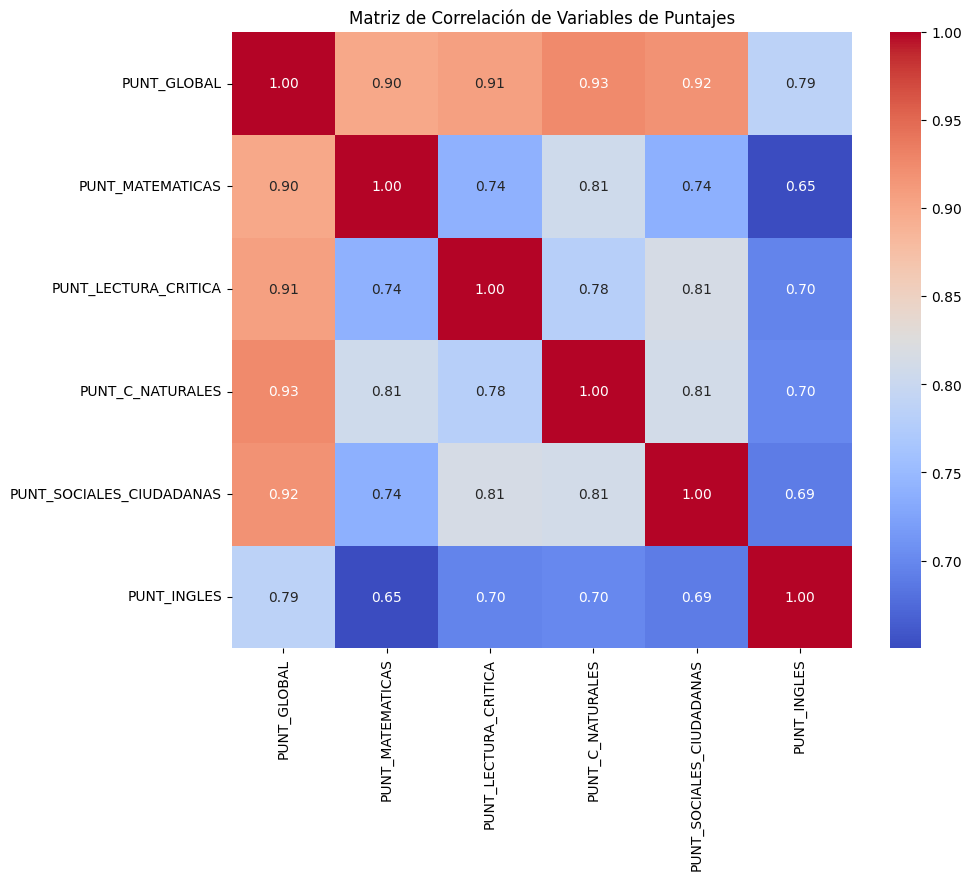

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las columnas de puntajes
score_cols = [
    'PUNT_GLOBAL',
    'PUNT_MATEMATICAS',
    'PUNT_LECTURA_CRITICA',
    'PUNT_C_NATURALES',
    'PUNT_SOCIALES_CIUDADANAS',
    'PUNT_INGLES'
]

# Calcular la matriz de correlación para estas variables
corr_matrix = df_filtered[score_cols].corr()

# Graficar la matriz de correlación utilizando un heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación de Variables de Puntajes en Colombia")
plt.show()


La matriz de correlación de los puntajes en las pruebas ICFES en Colombia revela relaciones positivas y significativas entre los diferentes componentes evaluados. En general, los estudiantes que destacan en una asignatura tienden a obtener buenos resultados en las demás. Por ejemplo, se observa que el PUNT_GLOBAL mantiene fuertes correlaciones con puntajes específicos como Matemáticas y Lectura Crítica, lo que indica que el rendimiento integral es consistente a lo largo de las áreas evaluadas. Asimismo, la alta correlación entre Matemáticas y Lectura Crítica sugiere que las habilidades cuantitativas y de comprensión lectora están estrechamente vinculadas en el contexto colombiano. Estas relaciones destacan que, en Colombia, el desempeño académico suele ser un indicador global de la capacidad del estudiante, evidenciando que los factores que impulsan el rendimiento en una disciplina tienden a favorecer también a las demás.